In [1]:
import torch

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cpu


In [2]:
import pandas as pd
import urllib.request
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Set Pandas display options
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

# Download the file using urllib
# Download the file using urllib
# url = 'https://github.com/jeffheaton/jheaton-ds2/rawmain/kdd-with-columns.csv'
filename = 'DMZServiciosN4_Web_U_EX240225.log'


if not os.path.isfile(filename):
        print('documento no encontrado :' + filename)
    
print(filename)
columnanombre = 'No cargo aun el archivo'
# Cargo titulos de columnas
with open(filename, 'r') as file:
    for line in file:
        if line.startswith('#Fields:'):
            # Eliminar el prefijo y el salto de línea, luego dividir por espacio
            columnanombre = line.replace('#Fields: ', '').strip().split()
            break

print(columnanombre)


# Se cargan los datos con las columnas a utilizar
cols_to_use = ['time', 'cs-method', 'cs-uri-stem', 'cs-username','c-ip','cs-host','sc-status'
                                                         ,'sc-bytes','cs-bytes','time-taken']

df = pd.read_csv(filename, sep=' ', names=columnanombre, comment='#',usecols=cols_to_use)
print("Read {} rows.".format(len(df)))

# Display 5 rows
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 15)
              
print(df)

DMZServiciosN4_Web_U_EX240225.log
['date', 'time', 's-computername', 's-ip', 'cs-method', 'cs-uri-stem', 'cs-uri-query', 's-port', 'cs-username', 'c-ip', 'cs(User-Agent)', 'cs(Referer)', 'cs-host', 'sc-status', 'sc-substatus', 'sc-win32-status', 'sc-bytes', 'cs-bytes', 'time-taken']
Read 232076 rows.
            time cs-method                  cs-uri-stem  cs-username  \
0       00:00:00      POST         /LuciaWS/awsdua.aspx         0642   
1       00:00:00       GET    /luciaws/axmovstkxml.aspx      TRN0038   
2       00:00:00      POST  /LuciaWSPR/aWSPrcRptV2.aspx            -   
3       00:00:00      POST  /LuciaWSPR/aWSPrcRptV2.aspx  DNA\OTR0662   
4       00:00:01      POST    /LuciaWsPr/awsprcrpt.aspx      otr5690   
...          ...       ...                          ...          ...   
232071  23:59:56       GET       /luciaws/afxmldua.aspx      bullmon   
232072  23:59:56      POST    /LuciaWsPr/awsprcrpt.aspx      otr5690   
232073  23:59:58      POST    /LuciaWsPr/awsprcrpt

In [4]:
### Comienza el trabajo con los datos para CATEGORIZAR LOS CAMPOS

In [3]:
### Campo sc-status 
# elimanmos todos los errores del aplicativo y solo nos quedamos con los 200 (ok)
#   Al eliminar esta columna evitamos tener aplitivos que no existen o sin usuario (401 y 404) ademas de erres del servidor 500 en el entrenamiento
#df  = df[df['sc-status'] == 200]


## eliminamos la columna sc-status
#df = df.drop('sc-status', axis=1)

# Crear la nueva columna 'status-cat' basada en la condición
df['status-cat'] = df['sc-status'].apply(lambda x: 'OK' if x == 200 else 'Otro')
# Convertir la nueva columna categorizada a variables one-hot-encoding (vector de 20  bits donde solo esta activo el que corresponde) 
status_dummies = pd.get_dummies(df['status-cat'])


# Convertir los valores one-hot a enteros y luego a cadenas
one_hot_str = status_dummies.astype(int).astype(str)
df['E'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
one_hot_str = ''

# Concatenar los valores one-hot al DataFrame original
#borro columna temporal agregada

df = df.drop('status-cat', axis=1)
status_dummies = ''
print (df['E'])



0         10
1         10
2         01
3         10
4         10
          ..
232071    10
232072    10
232073    10
232074    10
232075    10
Name: E, Length: 232076, dtype: object


In [4]:

### Campo cs-uri-stem o campo del aplicativo a invocar


# PARA NORMALIZAR - Reemplazar 'dna\' o 'DNA\' al comienzo de 'cs-username' por una cadena vacía, insensible a mayúsculas/minúsculas 
df['cs-uri-stem'] = df['cs-uri-stem'].str.split('/').str[-1]
                                                    

# Agrupar , contar, ordenar y obtener los 19 mas frecuentes  y el 20 va a ser el resto 'otros'
top_20_csuristem = df.groupby('cs-uri-stem')['cs-uri-stem'].count().sort_values(ascending=False).head(19).index.tolist()


# Crear una nueva columna que categoriza 'cs-username'
df['cs-uri-stem-cat'] = df['cs-uri-stem'].apply(lambda x: x if x in top_20_csuristem else 'otros')

# Convertir la nueva columna categorizada a variables one-hot-encoding (vector de 20  bits donde solo esta activo el que corresponde) 
csuristem_dummies = pd.get_dummies(df['cs-uri-stem-cat'])

# Convertir los valores one-hot a enteros y luego a cadenas
one_hot_str = csuristem_dummies.astype(int).astype(str)
df['P'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
one_hot_str = ''


#borro columna temporal agregada

# df = df.drop('cs-uri-stem-cat', axis=1) No lo borro pq lo uso en la grafica 
csuristem_dummies = ''
print(df['P'])


# Guardar la lista en un archivo de texto  las categorias que seran necesarias para evaluar el trafico neuvo con la misma categorizacion

with open('lista_categorias_csuristem.csv', 'w') as archivo:
    for elemento in top_20_csuristem:
        archivo.write("%s\n" % elemento)





0         00000000000000100000
1         00000000000000000001
2         00100000000000000000
3         00100000000000000000
4         00000000000000000010
                  ...         
232071    00010000000000000000
232072    00000000000000000010
232073    00000000000000000010
232074    00000000000000100000
232075    00000000000000000010
Name: P, Length: 232076, dtype: object


In [5]:

### Campo time
## Realizaremos una particion del tieme en 4 categorias . de 23 a 6 (hora de alto hacking), 6 a 9 y 19 a 23 y el central de 9 a 19
# Para ello se parte de un vector binario one-hot-encoding de 3 elementos (23 a 6 = 100 , de 9 a 19 = 010 y resto = 001

# Convertir la columna 'time' a datetime
# Dividir la cadena por ':' y quedarse con la parte antes del primer ':'
def categorizar_por_hora(time):
    # Primero, dividimos el string para extraer la hora
    hora = int(time.split(':')[0])  # Convertimos a entero el primer elemento luego de hacer split por ':'
    
    # Ahora, categorizamos según los rangos definidos
    if (6 <= hora < 9) :
        return '6a9'
    elif 9 <= hora < 19:
        return '9a19'
    elif hora >= 23 or hora < 6:
        return '23a6'
    else: # (19 <= hora < 23)
        return '19a23' 

# Aplicar la función para categorizar
df['time-cat'] = df['time'].apply(categorizar_por_hora)

              

# Agrupar , contar, ordenar y obtener los 19 mas frecuentes  y el 20 va a ser el resto 'otros'
lista_timeCategoria = ['6a9y19a23','9a19','23a6']



# Convertir la nueva columna categorizada a variables one-hot-encoding (vector de 20  bits donde solo esta activo el que corresponde) 
time_dummies = pd.get_dummies(df['time-cat'])


# Convertir los valores one-hot a enteros y luego a cadenas
one_hot_str = time_dummies.astype(int).astype(str)
df['H'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
one_hot_str = ''

#borro columna temporal agregada
time_dummies  = '' 
df = df.drop(['time-cat'], axis=1)
print(df['H'])


# Guardar la lista en un archivo de texto  las categorias que seran necesarias para evaluar el trafico neuvo con la misma categorizacion

with open('lista_categorias_time.csv', 'w') as archivo:
    for elemento in lista_timeCategoria:
        archivo.write("%s\n" % elemento)



0         0100
1         0100
2         0100
3         0100
4         0100
          ... 
232071    0100
232072    0100
232073    0100
232074    0100
232075    0100
Name: H, Length: 232076, dtype: object


In [6]:

### Campo cs-username


# PARA NORMALIZAR - Reemplazar 'dna\' o 'DNA\' al comienzo de 'cs-username' por una cadena vacía, insensible a mayúsculas/minúsculas 
df['cs-username'] = df['cs-username'].str.replace('^(?i)dna\\\\', '', regex=True)

# Agrupar por 'cs-username', contar, ordenar y obtener los 19 mas frecuentes  y el 20 va a ser el resto 'otros'
top_20_usernames = df.groupby('cs-username')['cs-username'].count().sort_values(ascending=False).head(19).index.tolist()

# Crear una nueva columna que categoriza 'cs-username'
df['cs-username-cat'] = df['cs-username'].apply(lambda x: x if x in top_20_usernames else 'otros')

# Convertir la nueva columna categorizada a variables one-hot-encoding (vector de 20  bits donde solo esta activo el que corresponde al usuario) 
username_dummies = pd.get_dummies(df['cs-username-cat'])
# Convertir los valores one-hot a enteros y luego a cadenas
one_hot_str = username_dummies.astype(int).astype(str)
df['U'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
one_hot_str = ''

username_dummies = ''
#borro columna temporal agregada

df = df.drop(['cs-username-cat'], axis=1)
print(df['U'])


# Guardar la lista en un archivo de texto  las categorias que seran necesarias para evaluar el trafico neuvo con la misma categorizacion

with open('lista_categorias_csusername.csv', 'w') as archivo:
    for elemento in top_20_usernames:
        archivo.write("%s\n" % elemento)



0         00100000000000000000
1         00000000000000000010
2         10000000000000000000
3         00000000100000000000
4         00000000000000001000
                  ...         
232071    00000000000001000000
232072    00000000000000001000
232073    00000000000000100000
232074    00100000000000000000
232075    00000000010000000000
Name: U, Length: 232076, dtype: object


In [7]:
### Campo cs-method



# PARA NORMALIZAR - crearemos un vector de 3 bit dodne (100 = GET; 010 = Put ; 001 = Otro
categoria_csmethod = ['GET','POST','OTROS']

# Crear una nueva columna que categoriza 'cs-username'
df['cs-method-cat'] = df['cs-method'].apply(lambda x: x if x in categoria_csmethod else 'otros')

# Convertir la nueva columna categorizada a variables one-hot-encoding (vector de 20  bits donde solo esta activo el que corresponde al usuario) 
method_dummies = pd.get_dummies(df['cs-method-cat'])
# Convertir los valores one-hot  enteros y luego a cadenas
one_hot_str = method_dummies.astype(int).astype(str)
df['V'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
one_hot_str = ''

method_dummies = ''
#borro columna temporal agregada

df = df.drop(['cs-method-cat'],axis=1)
print(df['V'])


# Guardar la lista en un archivo de texto  las categorias que seran necesarias para evaluar el trafico neuvo con la misma categorizacion

with open('lista_categorias_csmethod.csv', 'w') as archivo:
    for elemento in categoria_csmethod:
        archivo.write("%s\n" % elemento)

0         010
1         100
2         010
3         010
4         010
         ... 
232071    100
232072    010
232073    010
232074    010
232075    010
Name: V, Length: 232076, dtype: object


In [8]:
# DIRECCION Ip o c


# Función para procesar cada dirección IP
def procesar_ip(ip):
    octetos = ip.split('.')
    # lo pasamos a 3 digitos llenando de 0
    octetos = [octeto.zfill(3) for octeto in octetos]
    primer_octeto = int(octetos[0])
    segundo_octeto = int(octetos[1])
    
    # Comprueba los dos primeros octetos
    if primer_octeto == 172 and segundo_octeto == 20:
        # Si los dos primeros octetos son 172 y 20, respectivamente, toma solo los dos primeros
        return ''.join(octetos[:2])
    else:
        # De lo contrario, tom los tres primeros octetos
        return ''.join(octetos[:2]) # 
        # return ''.join(octetos[:3])

# Aplicar la función a la columna ip_address
df['ip_concat'] = df['c-ip'].apply(procesar_ip)

#df['ip_concat'] = df.apply(lambda row: int(f"{row['octet1']:03d}{row['octet2']:03d}"), axis=1)

#df['ip_concat'] = df.apply(lambda row: int(f"{row['octet1']:03d}{row['octet2']:03d}{row['octet3']:03d}"), axis=1)
top_20_IP = df.groupby('ip_concat')['ip_concat'].count().sort_values(ascending=False).head(19).index.tolist()
top_20_IP_Str = [str(ip) for ip in top_20_IP]

# Crear una nueva columna que categoriza 'cs-username'
df['c-ip-cat'] = df['ip_concat'].astype(str).apply(lambda x: x if x in top_20_IP_Str else 'otros')

# Convertir la nueva columna categorizada a variables one-hot-encoding (vector de 20  bits donde solo esta activo el que corresponde) 
cip_dummies = pd.get_dummies(df['c-ip-cat'])
# Convertir los valores one-hot a enteros y luego a cadenas
one_hot_str = cip_dummies.astype(int).astype(str)
df['I'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
one_hot_str = ''


cip_dummies = ''
top_20_IP_Str = ''
top_20_IP = ''
#borro columna temporal agregada

df = df.drop(['c-ip-cat'], axis=1)

print(df['I'])

print(top_20_IP)
with open('lista_categorias_IPClientes.csv', 'w') as archivo:
    for elemento in top_20_IP:
        archivo.write("%s\n" % elemento)




        

0         00000001000000000000
1         00000000000000010000
2         00000000000000000100
3         00000000000000000100
4         00000000000001000000
                  ...         
232071    00000000001000000000
232072    00000000000001000000
232073    00000000000001000000
232074    00000001000000000000
232075    00000000000000100000
Name: I, Length: 232076, dtype: object



In [9]:
### Campo cs-bytes categorizacion
import joblib
# Suponiendo que df es tu DataFrame y cs-byte es la columna de interés
# Asegúrate de que cs-byte sea numérico
df['cs-bytes'] = pd.to_numeric(df['cs-bytes'], errors='coerce').fillna(0)

# Escalamos los datos para mejorar la convergencia del GMM
scaler = StandardScaler()
cs_bytes_scaled = scaler.fit_transform(df[['cs-bytes']])

#Calculamos la Gaussiana y el numero optimo de categorias
n_components = np.arange(1, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cs_bytes_scaled) for n in n_components]

# Calcular el BIC para cada modelo
bic = [m.bic(cs_bytes_scaled) for m in models]

# Encontrar el número óptimo de componentes gaussianos
optimal_n_components = n_components[np.argmin(bic)]
print("Optimo " + str(optimal_n_components))

# En nuestro estudio el optimo = 16 y por eso lo ponemos a fuego
optimal_n_components = 16

gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=0)
gmm.fit(cs_bytes_scaled)

# Clasificar cada muestra en uno de los componentes gaussianos
df['cs-bytes-category'] = gmm.predict(cs_bytes_scaled)
cs_bytes_dummies = pd.get_dummies(df['cs-bytes-category'])

dummy_counts = cs_bytes_dummies.sum().sort_values(ascending=False)
# Convertir los valores one-hot a enteros y luego a cadenas
one_hot_str = cs_bytes_dummies.astype(int).astype(str)

df['C'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
# one_hot_str = ''


dummy_counts = ''
cs_bytes_dummies = ''

#borro columna temporal agregada

df = df.drop(['cs-bytes-category'], axis=1)

print(df['C'])

# Guardar el modelo entrenado en un archivo
joblib.dump(gmm, 'gmm_csByte.pkl')


Optimo 17
0         0000000000100000
1         0000000000100000
2         0000000000000001
3         0000000000000001
4         1000000000000000
                ...       
232071    0000000000100000
232072    1000000000000000
232073    0000000000000001
232074    0000000000100000
232075    0000000000000001
Name: C, Length: 232076, dtype: object


['gmm_csByte.pkl']

In [10]:
### Campo sc-bytes categorizacion
import joblib
# Suponiendo que df es tu DataFrame y cs-byte es la columna de interés
# Asegúrate de que cs-byte sea numérico
df['sc-bytes'] = pd.to_numeric(df['sc-bytes'], errors='coerce').fillna(0)

# Escalamos los datos para mejorar la convergencia del GMM
scaler = StandardScaler()
sc_bytes_scaled = scaler.fit_transform(df[['sc-bytes']])

#Calculamos la Gaussiana y el numero optimo de categorias
n_components = np.arange(1, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(sc_bytes_scaled) for n in n_components]

# Calcular el BIC para cada modelo
bic = [m.bic(sc_bytes_scaled) for m in models]

# Encontrar el número óptimo de componentes gaussianos
optimal_n_components = n_components[np.argmin(bic)]
print("Optimo " + str(optimal_n_components))

# En nuestro estudio el optimo = 19 y por eso lo ponemos a fuego
optimal_n_components = 18

gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=0)
gmm.fit(sc_bytes_scaled)

# Clasificar cada muestra en uno de los componentes gaussianos
df['sc-bytes-category'] = gmm.predict(sc_bytes_scaled)
sc_bytes_dummies = pd.get_dummies(df['sc-bytes-category'])

dummy_counts = sc_bytes_dummies.sum().sort_values(ascending=False)



# Convertir los valores one-hot a enteros y luego a cadenas
one_hot_str = sc_bytes_dummies.astype(int).astype(str)

df['S'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
one_hot_str = ''


dummy_counts = ''
sc_bytes_dummies = ''

#borro columna temporal agregada

df = df.drop(['sc-bytes-category'], axis=1)

print(df['S'])



# Guardar el modelo entrenado en un archivo
joblib.dump(gmm, 'gmm_ScByte.pkl')

# Para cargar el modelo entrenado más tarde
#loaded_gmm = joblib.load('gmm_model.pkl')


Optimo 19
0         100000000000000000
1         000000010000000000
2         000000010000000000
3         000000010000000000
4         000000010000000000
                 ...        
232071    000000010000000000
232072    000000010000000000
232073    000000010000000000
232074    100000000000000000
232075    000000010000000000
Name: S, Length: 232076, dtype: object


['gmm_ScByte.pkl']

In [11]:
### Campo time-taken categorizacion
import joblib
# Suponiendo que df es tu DataFrame y cs-byte es la columna de interés
# Asegúrate de que cs-byte sea numérico
df['time-taken'] = pd.to_numeric(df['time-taken'], errors='coerce').fillna(0)

# Escalamos los datos para mejorar la convergencia del GMM
scaler = StandardScaler()
time_taken_scaled = scaler.fit_transform(df[['time-taken']])

#Calculamos la Gaussiana y el numero optimo de categorias
n_components = np.arange(1, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(time_taken_scaled) for n in n_components]

# Calcular el BIC para cada modelo
bic = [m.bic(time_taken_scaled) for m in models]

# Encontrar el número óptimo de componentes gaussianos
optimal_n_components = n_components[np.argmin(bic)]
print("Optimo " + str(optimal_n_components))

# En nuestro estudio el optimo = 19 y por eso lo ponemos a fuego
optimal_n_components = 20

gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=0)
gmm.fit(time_taken_scaled)

# Clasificar cada muestra en uno de los componentes gaussianos
df['time-taken-cat'] = gmm.predict(time_taken_scaled)
time_taken_dummies = pd.get_dummies(df['time-taken-cat'])

time_taken_counts = time_taken_dummies.sum().sort_values(ascending=False)

# Convertir los valores one-hot a enteros y luego a cadenas
one_hot_str = time_taken_dummies.astype(int).astype(str)

df['T'] = one_hot_str.apply(lambda x: ''.join(x), axis=1)
one_hot_str = ''

time_taken_counts = ''
time_taken_dummies = ''

#borro columna temporal agregada

df = df.drop(['time-taken-cat'], axis=1)

print(df['T'])



# Guardar el modelo entrenado en un archivo
joblib.dump(gmm, 'gmm_time_taken.pkl')

# Para cargar el modelo entrenado más tarde
#loaded_gmm = joblib.load('gmm_model.pkl')


Optimo 19
0         10000000000000000000
1         10000000000000000000
2         00000000000010000000
3         10000000000000000000
4         00000000000000000010
                  ...         
232071    10000000000000000000
232072    00000000000000000010
232073    00000000000000000010
232074    10000000000000000000
232075    00000000000000000010
Name: T, Length: 232076, dtype: object


['gmm_time_taken.pkl']

In [ ]:
################ MODELO GRAFICO

In [12]:
#%matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt
# Crear un grafo dirigido para representar solicitudes de IP a URL
G = nx.DiGraph()
#G.add_node('ip_concat', color='blue')
#G.add_node('cs-method', color='green')
#G.add_node('cs-uri-stem-cat', color='red')
unique_node_types = df['cs-uri-stem-cat'].unique()
G.add_nodes_from(unique_node_types, color='blue')
unique_node_types = df['ip_concat'].unique()
G.add_nodes_from(unique_node_types, color='red')
unique_node_types = df['cs-method'].unique()
G.add_nodes_from(unique_node_types, color='green')
# Añadir aristas basadas en las columnas 'c-ip' y 'cs-uri-stem' del DataFrame
for index, row in df.iterrows():
    G.add_edge(row['ip_concat'], row['cs-uri-stem-cat'], color='blue')
    G.add_edge(row['cs-method'], row['cs-uri-stem-cat'], color='red')




In [47]:
node_colors = [G.nodes[node].get('color', 'yellow') for node in G.nodes()]




#node_colors = {'ip_concat': 'blue', 'cs-method': 'green','cs-uri-stem-cat': 'red'}
#nx.draw_networkx(G, with_labels=True, node_color=node_colors)
#plt.show()
nx.draw_networkx(G, with_labels=True, node_color=[node_colors[node] for node in G.nodes()], font_size=3, node_size=100, edge_color=[G[u][v]['color'] for u,v in G.edges()])


# Obtener las etiquetas de los nodos
#labels = nx.draw_networkx_labels(G, pos,  font_size=1)  # Cambiar el tamaño de la fuente aquí

# Mostrar el grafo
plt.show()

TypeError: list indices must be integers or slices, not str

In [13]:
# Obtener información detallada sobre el grafo
print("Número de nodos:", G.number_of_nodes())
print("Número de aristas:", G.number_of_edges())
#print("Nodos:", list(G.nodes()))
#print("Aristas:", list(G.edges()))

Número de nodos: 85
Número de aristas: 165


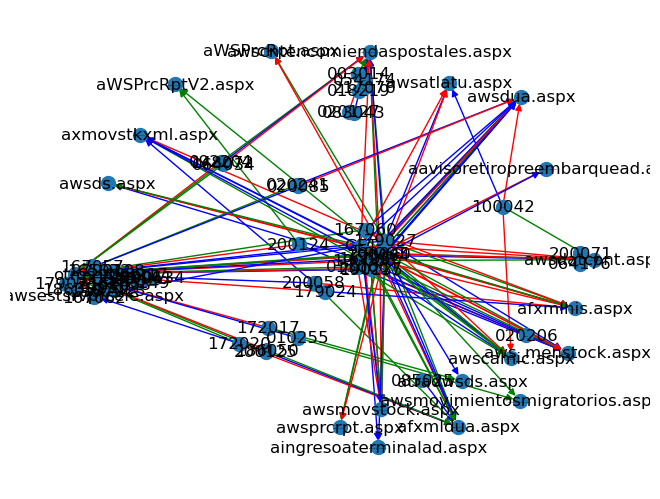

In [88]:
# Dibujar el grafo
pos = nx.spring_layout(G)  # Calcular la disposición de los nodos
nx.draw(G, pos, edge_color=edge_colors,with_labels=True, node_size=100)

# Obtener las etiquetas de los nodos
labels = nx.draw_networkx_labels(G, pos, font_size=1)  # Cambiar el tamaño de la fuente aquí

# Mostrar el gráfico
plt.show()

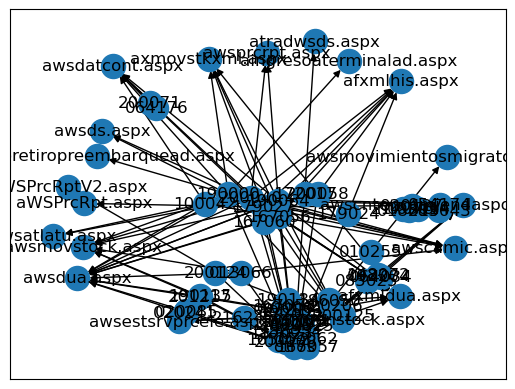

In [19]:
nx.draw_networkx(G)
plt.show(block=True)

In [ ]:
# Genero nuevo dataframe convirtiendo cada fila incial categorizada en la nueva estructura

In [14]:
# Lista de nuevas filas
new_vector = []

# Iterar sobre cada fila del DataFrame original
for index, row in df.iterrows():
    # Crear tres nuevas filas con modificaciones
    # P*20 + V * 3 + U*20 + I*20 +C*16 + S*18 + H*4 + T*10 + E*3   
    #V=Get o post u otro
    #P= Programa ejecutado
    #U= Usuario
    #I= IPCliente
    #C= CsByte recibidos
    #S= ScByte enviados.
    #H= Hora (4 posibles)
    #T= Time-Tiken (tiempo del a consulta)
    #E= Codigo de error
    V_Vacio = np.zeros(3, dtype=bool)
    P_Vacio = np.zeros(20, dtype=bool)
    U_Vacio = np.zeros(20, dtype=bool)
    I_Vacio = np.zeros(20, dtype=bool)
    C_Vacio = np.zeros(16, dtype=bool)
    S_Vacio = np.zeros(18, dtype=bool)
    H_Vacio = np.zeros(4, dtype=bool)
    T_Vacio = np.zeros(19, dtype=bool)
    E_Vacio = np.zeros(3, dtype=bool)
    # Convertir las matrices booleanas a cadenas
    V_Vacio_str = ''.join(map(str, V_Vacio.astype(int)))
    P_Vacio_str = ''.join(map(str, U_Vacio.astype(int)))
    U_Vacio_str = ''.join(map(str, U_Vacio.astype(int)))
    I_Vacio_str = ''.join(map(str, I_Vacio.astype(int)))
    C_Vacio_str = ''.join(map(str, C_Vacio.astype(int)))
    S_Vacio_str = ''.join(map(str, S_Vacio.astype(int)))
    H_Vacio_str = ''.join(map(str, H_Vacio.astype(int)))
    T_Vacio_str = ''.join(map(str, T_Vacio.astype(int)))
    E_Vacio_str = ''.join(map(str, E_Vacio.astype(int)))

    # Concatenar todas las cadenas
    NodoAplicacion = row['P'] + V_Vacio_str + U_Vacio_str + I_Vacio_str + C_Vacio_str + S_Vacio_str + H_Vacio_str + T_Vacio_str + E_Vacio_str
       
    # P*20 + V * 3 + U*20 + I*20 +C*10 + H*4 + T*10 + E*3   
    NodoIpCliente =  P_Vacio_str+ V_Vacio_str  + U_Vacio_str + row['I'] + C_Vacio_str+ S_Vacio_str + H_Vacio_str + T_Vacio_str + E_Vacio_str 
    # P*20 + V * 3 + U*20 + I*20 +C*10 + H*4 + T*10 + E*3   
    NodoUsuario   = P_Vacio_str+ V_Vacio_str + row['U'] + I_Vacio_str + C_Vacio_str + S_Vacio_str + H_Vacio_str + T_Vacio_str + E_Vacio_str 
    # P*20 + V * 3 + U*20 + I*20 +C*10 + H*4 + T*10 + E*3   
    NodoConexion  =  P_Vacio_str + row['V']+  U_Vacio_str + I_Vacio_str +row['C']+row['S']+row['H']+row['T'] +row['E']
    #print (NodoConexion)
    #print (NodoIpCliente)
    #print (NodoUsuario)
    #print (NodoAplicacion)
    #AristaTipo1  = '001' + NodoConexion + NodoUsuario
    A1 = np.zeros(3, dtype=bool)
    A1[2] = True
    A1 = ''.join(A1.astype(int).astype(str))
    Arista1  = A1 + NodoConexion + NodoUsuario
    #print (A1)
    #AristaTipo2  = '010'
    A2 = np.zeros(3, dtype=bool)
    A2[1] = True
    A2 = ''.join(A2.astype(int).astype(str))
    Arista2  = A2 + NodoConexion + NodoAplicacion
    #AristaTipo3  = '100'
    A3 = np.zeros(3, dtype=bool)
    A3 [0] = True
    A3 = ''.join(A3.astype(int).astype(str))
    Arista3  = A3 + NodoConexion + NodoIpCliente
 
    longitudes = [len(cadena) for cadena in NodoIpCliente]

   
    new_vector.append(Arista1)
    new_vector.append(Arista2)
    new_vector.append(Arista3)
    
    #if index >= 10000:
     #   break
    
       
    

# Crear un nuevo DataFrame con las filas modificadas
#df_AEntrenar = pd.DataFrame(new_rows)

# Mostrar el nuevo DataFrame
#print(df_AEntrenar)

In [15]:
# convierte  a una estructura de bits
def string_a_lista(cadena):
    return [int(char) for char in cadena]

# Convertir cada cadena en una lista de enteros y luego en un tensor
tensores = [torch.tensor(string_a_lista(cadena)) for cadena in new_vector]

# Concatenar los tensores en una sola dimensión
tensor_concatenado = torch.stack(tensores)

print(tensor_concatenado)

tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])


In [18]:
#Verificar longitudes 
#longitudes = [len(cadena) for cadena in tensor_concatenado]
#print(longitudes)

In [64]:


# Convertir la cadena en una lista de enteros
#enteros = [int(char) for char in cadena_binaria]

# Crear un tensor de PyTorch a partir de la lista de enteros
#tensor_binario = torch.tensor(enteros)

#print(tensor_binario)

NameError: name 'cadena_binaria' is not defined

In [16]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(
    tensor_concatenado, test_size=0.25, random_state=42)
print (type(x_normal_train))
print (x_normal_train)
x_normal_train = np.array(x_normal_train)

<class 'torch.Tensor'>
tensor([[0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])


In [ ]:
### MODELADO 


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class BifurcatedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, encoding_dim2, decoder_dim2 ,decoder_dim3, output_dim1, output_dim2, output_dim3):
        super(BifurcatedAutoencoder, self).__init__()
        
        # Encoder inicial
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.Sigmoid()
        )

        #  Encoder nivel 2
        self.encoder2 = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim2),
            nn.Sigmoid()
        )

        # Decoder Salida 1
        self.decoder1 = nn.Sequential(
            nn.Linear(encoding_dim2, output_dim1),
            nn.ReLU(True)
        )
        
        # Decoder a siguiente paralelo 2
        self.decoder2 = nn.Sequential(
            nn.Linear(encoding_dim2, decoder_dim2),
            nn.Sigmoid()
        )
                
        # Decoder 2 a salida paralelo 2
        self.decoder2a = nn.Sequential(
            nn.Linear(decoder_dim2, output_dim2),
            nn.ReLU(True)
        )
        # Decoder a siguiente paralelo 3
        self.decoder3 = nn.Sequential(
            nn.Linear(encoding_dim2, decoder_dim3),
            nn.Sigmoid()
        )
        # Decoder 2 a salida paralelo 3
        self.decoder3a = nn.Sequential(
            nn.Linear(decoder_dim3, output_dim3),
            nn.ReLU(True)
        )

    
    def forward(self, x):
        encoded = self.encoder(x)
        encoded2 = self.encoder2(encoded)
        output_dim1 = self.decoder1(encoded2)
        decoded2 = self.decoder2(encoded2)
        output_dim2 = self.decoder2a(decoded2)
        decoded3 = self.decoder3(encoded2)
        output_dim3 = self.decoder3a(decoded3)
        return output_dim1, output_dim2,output_dim3 #torch.cat((output_dim1, output_dim2,output_dim3), dim=1)

# Dimensiones ejemplo
input_dim = 249  # Dimensión del vector de entrada
encoding_dim = 180 # Dimensión del espacio latente (codificado)
encoding_dim2 = 70 
decoder_dim2 = 110
decoder_dim3 = 110
output_dim1 = 3  # Dimensiones de las partes de salida
output_dim2 = 123
output_dim3 = 123

# Crear el modelo
model = BifurcatedAutoencoder(input_dim, encoding_dim, encoding_dim2 ,decoder_dim2, decoder_dim3, output_dim1, output_dim2, output_dim3)

# Imprimir el modelo para ver su estructura
print(model)


BifurcatedAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=249, out_features=180, bias=True)
    (1): Sigmoid()
  )
  (encoder2): Sequential(
    (0): Linear(in_features=180, out_features=70, bias=True)
    (1): Sigmoid()
  )
  (decoder1): Sequential(
    (0): Linear(in_features=70, out_features=3, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder2): Sequential(
    (0): Linear(in_features=70, out_features=110, bias=True)
    (1): Sigmoid()
  )
  (decoder2a): Sequential(
    (0): Linear(in_features=110, out_features=123, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder3): Sequential(
    (0): Linear(in_features=70, out_features=110, bias=True)
    (1): Sigmoid()
  )
  (decoder3a): Sequential(
    (0): Linear(in_features=110, out_features=123, bias=True)
    (1): ReLU(inplace=True)
  )
)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors and move them to the appropriate device
x_normal_train_tensor = torch.tensor(x_normal_train).float().to(device)
#x_normal_tensor = torch.tensor(x_normal).float().to(device)
#x_attack_tensor = torch.tensor(x_attack).float().to(device)

# Create DataLoader for batch processing
train_data = TensorDataset(x_normal_train_tensor, x_normal_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [178]:
#print (x_normal_train_tensor)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])


In [120]:
#Este modelo toma un vector de entrada (supongamos que es un embedding de dimensión 64), lo codifica en un espacio latente de dimensión 32, 
# y luego lo decodifica en tres partes de salida 


In [72]:
#Para entrenar este modelo, necesitarás definir una función de pérdida y un optimizador. Aquí utilizaremos el error cuadrático medio
# como función de pérdida y el optimizador Adam
train_data = TensorDataset(x_normal_train_tensor, x_normal_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
print (train_loader)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
inputs = train_loader
losses2 = []
# Suponiendo que tienes los datos de entrenamiento en variables 'inputs' y 'targets1', 'targets2', 'targets3'
# inputs: Tensor de entradas
# targets1, targets2, targets3: Tres partes del tensor objetivo
num_epochs = 500
# Un ciclo de entrenamiento
for epoch2 in range(num_epochs):
    for inputs, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # MSE entre entrada y salida reconstruida
        loss.backward()
        optimizer.step()
    
   # if epoch % 10 == 0:
    print(f'Epoch [{epoch2+1}/{num_epochs}], Loss: {loss.item()}')
    losses.append(loss.item())
    # Graficar la pérdida en función de las épocas
    plt.plot(range(1, num_epochs+1), losses, label='Loss')
    plt.xlabel('epoc')
    plt.ylabel('Pérdida')
    plt.title('Pérdida durante el entrenamiento')
    plt.legend()

AttributeError: 'tuple' object has no attribute 'size'

Epoch [1/100], Loss: 0.2619738280773163
Epoch [2/100], Loss: 0.22613762319087982
Epoch [3/100], Loss: 0.12557527422904968
Epoch [4/100], Loss: 0.1761561632156372
Epoch [5/100], Loss: 0.1891007423400879
Epoch [6/100], Loss: 0.18849799036979675
Epoch [7/100], Loss: 0.15116065740585327
Epoch [8/100], Loss: 0.1394159346818924
Epoch [9/100], Loss: 0.16531185805797577
Epoch [10/100], Loss: 0.13670599460601807
Epoch [11/100], Loss: 0.1156282126903534
Epoch [12/100], Loss: 0.16320402920246124
Epoch [13/100], Loss: 0.15266504883766174
Epoch [14/100], Loss: 0.08822663873434067
Epoch [15/100], Loss: 0.17735634744167328
Epoch [16/100], Loss: 0.09123846143484116
Epoch [17/100], Loss: 0.11412250250577927
Epoch [18/100], Loss: 0.17464634776115417
Epoch [19/100], Loss: 0.12646803259849548
Epoch [20/100], Loss: 0.1249624490737915
Epoch [21/100], Loss: 0.13911482691764832
Epoch [22/100], Loss: 0.15296600759029388
Epoch [23/100], Loss: 0.14965379238128662
Epoch [24/100], Loss: 0.16410721838474274
Epoch [

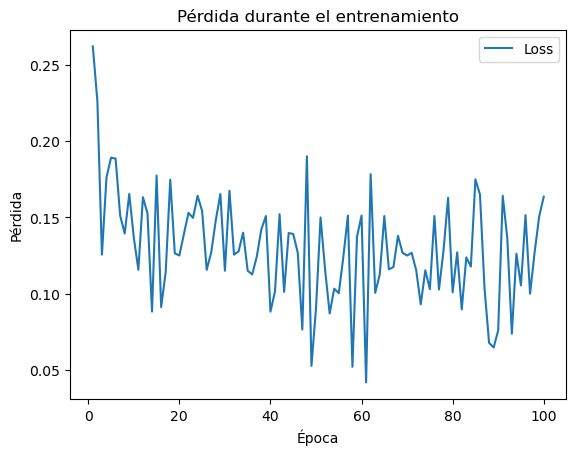

In [19]:
#Para entrenar este modelo, necesitarás definir una función de pérdida y un optimizador. Aquí utilizaremos el error cuadrático medio
# como función de pérdida y el optimizador Adam
train_data = TensorDataset(x_normal_train_tensor, x_normal_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
inputs = train_loader
losses = [] # Para graficar la loss
# Suponiendo que tienes los datos de entrenamiento en variables 'inputs' y 'targets1', 'targets2', 'targets3'
# inputs: Tensor de entradas
# targets1, targets2, targets3: Tres partes del tensor objetivo
num_epochs = 100
# Un ciclo de entrenamiento
for epoch in range(num_epochs):
    for inputs, _ in train_loader:
        optimizer.zero_grad()
        outputs1, outputs2, outputs3 = model(inputs)  # Separar las salidas en partes individuales
        loss1 = criterion(outputs1, inputs[:, :output_dim1])  # Calcular el error para la primera parte de la salida
        loss2 = criterion(outputs2, inputs[:, output_dim1:output_dim1+output_dim2])  # Calcular el error para la segunda parte de la salida
        loss3 = criterion(outputs3, inputs[:, output_dim1+output_dim2:])  # Calcular el error para la tercera parte de la salida
        total_loss = loss1 + loss2 + loss3  # Sumar los errores individuales
        total_loss.backward()
        optimizer.step()
    
   # if epoch % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item()}')
    losses.append(total_loss.item())

##################
#Tengo que ingresar 3 input. 
#funcion ( )
#outputs1, outputs2, outputs3 = model(inputs)  # Separar las salidas en partes individuales
 #       loss1 = criterion(outputs1, inputs[:, :output_dim1])  # Calcular el error para la primera parte de la salida
  #      loss2 = criterion(outputs2, inputs[:, output_dim1:output_dim1+output_dim2])  # Calcular el error para la segunda parte de la salida
   #     loss3 = criterion(outputs3, inputs[:, output_dim1+output_dim2:])  # Calcular el error para la tercera parte de la salida
    #    total_loss = loss1 + loss2 + loss3 
#total_loss
#Calucar como alternativa el error en cada edge o el error en promedio de los 3.

########



# Graficar la pérdida en función de las épocas
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.xlabel('epoc')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

In [ ]:
# Graficar la pérdida en función de las épocas
plt.plot(range(1, num_epochs+1), losses, label='Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()